In [ ]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# 경로 설정
IMAGE_DIR = r"C:\Users\607-03\Desktop\battery3000\battery3000\images"
JSON_DIR = r"C:\Users\607-03\Desktop\battery3000\battery3000\labels"

# 클래스 정의 (0: 정상, 1: 오염, 2: 손상)
CLASS_MAP = {
    "Normal": 0,
    "Pollution": 1,
    "Damaged": 2
}

# 이미지 크기 설정
IMG_SIZE = (128, 128)

# 데이터 로드 함수
def load_data(image_dir, json_dir, max_samples=3000):
    """JSON 파일을 읽어 이미지 및 라벨 데이터를 로드하는 함수"""

    data = []
    labels = []

    json_files = [f for f in os.listdir(json_dir) if f.endswith(".json")]
    if not json_files:
        raise FileNotFoundError(f"No JSON annotation files found in {json_dir}")

    samples_count = 0

    for json_file in json_files:
        json_path = os.path.join(json_dir, json_file)
        with open(json_path, "r", encoding="utf-8") as f:
            anno = json.load(f)

        img_path = os.path.join(image_dir, anno["image_info"]["file_name"])

        # 이미지 파일 존재 여부 확인
        if not os.path.exists(img_path):
            continue

        # 이미지 로드 및 전처리
        img = cv2.imread(img_path)
        img = cv2.resize(img, IMG_SIZE)
        img = img / 255.0

        # 라벨 할당 (기본값: 정상)
        label = CLASS_MAP["Normal"]
        if "defects" in anno and anno["defects"]:
            for defect in anno["defects"]:
                defect_type = defect["name"]
                if defect_type == "Pollution":
                    label = CLASS_MAP["Pollution"]
                elif defect_type == "Damaged":
                    label = CLASS_MAP["Damaged"]
                break

        data.append(img)
        labels.append(label)

        samples_count += 1
        if samples_count >= max_samples:
            break

    return np.array(data), np.array(labels)

# 데이터 로드
X, y = load_data(IMAGE_DIR, JSON_DIR, max_samples=3000)

# 데이터 분할 (훈련 80%, 테스트 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 데이터 증강 (손상 데이터 샘플이 적기 때문에 증강 적용)
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

damaged_indices = np.where(y_train == 2)[0]
for i in damaged_indices:
    img = X_train[i]
    img = img.reshape((1,) + img.shape)
    it = datagen.flow(img, batch_size=1)

    for _ in range(5):
        aug_img = next(it).reshape(X_train[i].shape)
        X_train = np.append(X_train, [aug_img], axis=0)
        y_train = np.append(y_train, [y_train[i]], axis=0)

# 라벨을 One-Hot Encoding 처리
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

# 클래스 가중치 계산 (데이터 불균형 보정)
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# CNN 모델 생성
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# 모델 컴파일
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 모델 학습
EPOCHS = 10
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=EPOCHS, batch_size=32, class_weight=class_weight_dict)

# 모델 저장
model.save("battery_cnn_model_final.h5")

C:\Users\607-03\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.4105 - loss: 1.3002 - val_accuracy: 0.3533 - val_loss: 0.7659
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.6067 - loss: 0.5619 - val_accuracy: 0.5017 - val_loss: 0.6152
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.7377 - loss: 0.4523 - val_accuracy: 0.5250 - val_loss: 0.6506
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - accuracy: 0.6939 - loss: 0.4822 - val_accuracy: 0.4583 - val_loss: 0.8987
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.7401 - loss: 0.4627 - val_accuracy: 0.5483 - val_loss: 0.6208
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.7149 - loss: 0.4580 - val_accuracy: 0.5350 - val_loss: 0.6179
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 125ms/step - accuracy: 0.7008 - loss: 0.4645 - val_accuracy: 0.7050 - val_loss: 0.5554
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.7497 - loss: 0.4359 - val_accu

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step

📊 [정상 vs 불량 성능 평가]
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99       186
   Defective       0.99      1.00      0.99       414

    accuracy                           0.99       600
   macro avg       0.99      0.99      0.99       600
weighted avg       0.99      0.99      0.99       600



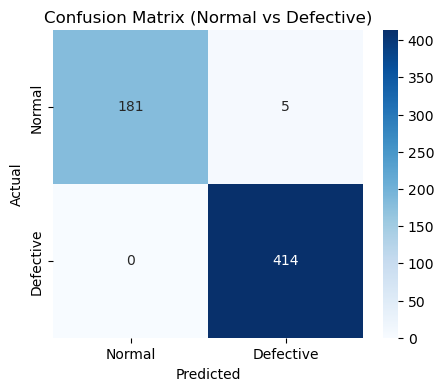


✔ 최종 정확도 (Normal vs Defective): 99.17%


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 🔹 모델 로드
model = load_model("battery_cnn_model_final.h5")

# 🔹 테스트 데이터 예측
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)  # 예측된 클래스
y_true = np.argmax(y_test, axis=1)  # 실제 정답 클래스

# 🔹 "Pollution(오염) + Damaged(손상)" → 하나의 "불량" 클래스로 통합
y_true_binary = np.where(y_true == 0, 0, 1)  # 0: 정상, 1: 불량
y_pred_binary = np.where(y_pred_classes == 0, 0, 1)  # 0: 정상, 1: 불량

# 🔹 정확도, 정밀도, 재현율, F1-score 출력
print("\n📊 [정상 vs 불량 성능 평가]")
print(classification_report(y_true_binary, y_pred_binary, target_names=["Normal", "Defective"]))

# 🔹 혼동 행렬 계산 및 시각화
cm = confusion_matrix(y_true_binary, y_pred_binary)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Defective"], yticklabels=["Normal", "Defective"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Normal vs Defective)")
plt.show()

# 🔹 최종 정확도 출력
accuracy = accuracy_score(y_true_binary, y_pred_binary)
print(f"\n✔ 최종 정확도 (Normal vs Defective): {accuracy * 100:.2f}%")

In [ ]:
import os
import json
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import random
import gc
import time

# 재현성을 위한 시드 설정
# 딥러닝 결과의 일관성을 유지하기 위해 여러 라이브러리의 난수 생성기에 시드값을 설정합니다.
def set_seed(seed=42):
    """
    여러 라이브러리의 난수 생성기에 동일한 시드값을 설정하여 실험 결과의 재현성을 보장합니다.

    Args:
        seed (int): 설정할 시드값. 기본값은 42입니다.
    """
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    print(f"시드가 {seed}로 설정되었습니다.")

# 시드 설정 호출
set_seed(42)

# 경로 설정
IMAGE_DIR = r"C:\Users\607-03\Desktop\battery3000\battery3000\images"
JSON_DIR = r"C:\Users\607-03\Desktop\battery3000\battery3000\labels"

# 클래스 정의 (0: 정상, 1: 오염, 2: 손상)
CLASS_MAP = {
    "Normal": 0,
    "Pollution": 1,
    "Damaged": 2
}

# 역매핑 정의 (숫자 -> 클래스명)
REVERSE_CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}

# 이미지 크기 설정
IMG_SIZE = (128, 128)

# 데이터 로드 함수
def load_data(image_dir, json_dir, max_samples=3000):
    """
    JSON 파일을 읽어 이미지 및 라벨 데이터를 로드하는 함수입니다.

    이 함수는 다음과 같은 작업을 수행합니다:
    1. JSON 디렉토리에서 모든 JSON 파일을 탐색합니다.
    2. 각 JSON 파일에서 이미지 파일명과 결함 정보를 추출합니다.
    3. 해당 이미지를 로드하고 전처리합니다 (크기 조정 및 정규화).
    4. 결함 정보에 따라 클래스 라벨을 할당합니다.
    5. 최대 샘플 수에 도달할 때까지 데이터를 수집합니다.

    Args:
        image_dir (str): 이미지 파일이 저장된 디렉토리 경로
        json_dir (str): JSON 주석 파일이 저장된 디렉토리 경로
        max_samples (int): 로드할 최대 샘플 수. 기본값은 3000입니다.

    Returns:
        tuple: (데이터 배열, 라벨 배열) 형태의 튜플

    Raises:
        FileNotFoundError: JSON 파일이 디렉토리에 없는 경우 발생
    """

    data = []
    labels = []
    file_paths = []  # 파일 경로 저장을 위한 리스트 추가

    json_files = [f for f in os.listdir(json_dir) if f.endswith(".json")]
    if not json_files:
        raise FileNotFoundError(f"No JSON annotation files found in {json_dir}")

    samples_count = {'Normal': 0, 'Pollution': 0, 'Damaged': 0}
    total_count = 0
    skipped_count = 0

    print(f"총 {len(json_files)}개의 JSON 파일을 처리합니다...")

    # tqdm을 사용하여 진행 상황 표시
    for json_file in tqdm(json_files, desc="데이터 로딩"):
        json_path = os.path.join(json_dir, json_file)

        try:
            with open(json_path, "r", encoding="utf-8") as f:
                anno = json.load(f)

            img_path = os.path.join(image_dir, anno["image_info"]["file_name"])

            # 이미지 파일 존재 여부 확인
            if not os.path.exists(img_path):
                skipped_count += 1
                continue

            # 이미지 로드 및 전처리
            img = cv2.imread(img_path)
            if img is None:
                skipped_count += 1
                continue

            # 이미지 채널 확인 및 수정
            if len(img.shape) == 2:  # 흑백 이미지인 경우
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
            elif img.shape[2] == 4:  # RGBA 이미지인 경우
                img = img[:, :, :3]  # Alpha 채널 제거

            # 이미지 크기 조정
            img = cv2.resize(img, IMG_SIZE)

            # BGR에서 RGB로 변환 (Matplotlib 시각화를 위해)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # 정규화 (0-1 범위로 조정)
            img = img / 255.0

            # 라벨 할당 (기본값: 정상)
            label = CLASS_MAP["Normal"]
            if "defects" in anno and anno["defects"]:
                for defect in anno["defects"]:
                    defect_type = defect["name"]
                    if defect_type == "Pollution":
                        label = CLASS_MAP["Pollution"]
                    elif defect_type == "Damaged":
                        label = CLASS_MAP["Damaged"]
                    break

            # 클래스별 샘플 수 추적
            label_name = REVERSE_CLASS_MAP[label]
            samples_count[label_name] += 1

            data.append(img)
            labels.append(label)
            file_paths.append(img_path)  # 파일 경로 저장

            total_count += 1

            # 최대 샘플 수 도달 확인
            if total_count >= max_samples:
                break

        except Exception as e:
            print(f"파일 {json_file} 처리 중 오류 발생: {e}")
            skipped_count += 1
            continue

    print(f"데이터 로딩 완료: 총 {total_count}개 샘플 (스킵됨: {skipped_count}개)")
    print(f"클래스별 분포: {samples_count}")

    return np.array(data), np.array(labels), file_paths

# 이미지 시각화 함수
def visualize_samples(data, labels, file_paths, num_samples=5):
    """
    데이터셋에서 무작위로 샘플을 선택하여 시각화하는 함수입니다.

    Args:
        data (np.array): 이미지 데이터 배열
        labels (np.array): 이미지 라벨 배열
        file_paths (list): 이미지 파일 경로 리스트
        num_samples (int): 시각화할 샘플 수. 기본값은 5입니다.
    """
    plt.figure(figsize=(15, 3*num_samples))

    # 클래스별 샘플 인덱스
    normal_indices = np.where(labels == CLASS_MAP["Normal"])[0]
    pollution_indices = np.where(labels == CLASS_MAP["Pollution"])[0]
    damaged_indices = np.where(labels == CLASS_MAP["Damaged"])[0]

    # 각 클래스에서 최대 num_samples개 선택
    for i, (class_name, indices) in enumerate([
        ("Normal", normal_indices),
        ("Pollution", pollution_indices),
        ("Damaged", damaged_indices)
    ]):
        samples = min(num_samples, len(indices))
        if samples == 0:
            continue

        selected_indices = np.random.choice(indices, samples, replace=False)

        for j, idx in enumerate(selected_indices):
            ax = plt.subplot(3, num_samples, i*num_samples + j + 1)
            plt.imshow(data[idx])
            plt.title(f"{class_name}\n{os.path.basename(file_paths[idx])}")
            plt.axis("off")

    plt.tight_layout()
    plt.savefig("data_samples.png")
    plt.show()

# 이미지 전처리 및 분석 함수
def analyze_image_stats(data):
    """
    이미지 데이터셋의 통계를 분석하고 시각화하는 함수입니다.

    Args:
        data (np.array): 이미지 데이터 배열
    """
    print("이미지 데이터 분석")
    print(f"데이터 형태: {data.shape}")
    print(f"데이터 타입: {data.dtype}")
    print(f"최소값: {data.min()}")
    print(f"최대값: {data.max()}")
    print(f"평균값: {data.mean()}")
    print(f"표준편차: {data.std()}")

    # 채널별 히스토그램
    plt.figure(figsize=(15, 5))

    channel_names = ['Red', 'Green', 'Blue']
    for i in range(3):
        plt.subplot(1, 3, i+1)
        channel_data = data[:, :, :, i].flatten()
        plt.hist(channel_data, bins=50, alpha=0.7)
        plt.title(f'{channel_names[i]} Channel')
        plt.xlabel('Pixel Value')
        plt.ylabel('Frequency')

    plt.tight_layout()
    plt.savefig("pixel_histogram.png")
    plt.show()

# 데이터 증강을 위한 이미지 시각화 함수
def visualize_augmentations(image, datagen, num_augmentations=5):
    """
    단일 이미지에 대한 데이터 증강 결과를 시각화하는 함수입니다.

    Args:
        image (np.array): 증강할 원본 이미지
        datagen (ImageDataGenerator): 데이터 증강을 위한 생성기
        num_augmentations (int): 생성할 증강 이미지 수. 기본값은 5입니다.
    """
    plt.figure(figsize=(15, 3))

    # 원본 이미지 표시
    plt.subplot(1, num_augmentations+1, 1)
    plt.imshow(image)
    plt.title("Original")
    plt.axis("off")

    # 증강된 이미지 생성 및 표시
    img = image.reshape((1,) + image.shape)
    it = datagen.flow(img, batch_size=1)

    for i in range(num_augmentations):
        plt.subplot(1, num_augmentations+1, i+2)
        aug_img = next(it)[0]
        plt.imshow(aug_img)
        plt.title(f"Augmentation {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("data_augmentation_examples.png")
    plt.show()

# 메모리 정리 함수
def clean_memory():
    """
    메모리 사용량을 줄이기 위해 가비지 컬렉션을 실행하고 텐서플로우 캐시를 정리합니다.
    """
    gc.collect()
    tf.keras.backend.clear_session()

# 성능 시각화 함수
def visualize_training_performance(history):
    """
    모델 학습 성능을 시각화하는 함수입니다.

    Args:
        history: 모델 학습 후 반환된 History 객체
    """
    plt.figure(figsize=(12, 5))

    # 정확도 그래프
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.savefig("training_performance.png")
    plt.show()

# 혼동 행렬 시각화 함수
def visualize_confusion_matrix(y_true, y_pred, class_names):
    """
    모델의 예측 결과를 혼동 행렬로 시각화하는 함수입니다.

    Args:
        y_true (np.array): 실제 클래스 라벨
        y_pred (np.array): 예측된 클래스 라벨
        class_names (list): 클래스 이름 리스트
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig("confusion_matrix.png")
    plt.show()

# 데이터 로드 (파일 경로 추가로 반환)
print("데이터 로드 시작...")
start_time = time.time()
X, y, file_paths = load_data(IMAGE_DIR, JSON_DIR, max_samples=3000)
print(f"데이터 로드 완료: {time.time() - start_time:.2f}초 소요")

# 데이터 세트 분석
print("\n데이터 세트 기본 정보:")
print(f"X 형태: {X.shape}, y 형태: {y.shape}")
print(f"클래스 분포: {np.bincount(y)}")

# 랜덤 샘플 시각화
print("\n랜덤 샘플 시각화...")
visualize_samples(X, y, file_paths, num_samples=4)

# 이미지 통계 분석
print("\n이미지 통계 분석...")
analyze_image_stats(X)

# 데이터 분할 (훈련 80%, 테스트 20%)
X_train, X_test, y_train, y_test, paths_train, paths_test = train_test_split(
    X, y, file_paths, test_size=0.2, random_state=42, stratify=y
)

print("\n데이터 분할 완료:")
print(f"훈련 세트: {X_train.shape[0]}개 샘플")
print(f"테스트 세트: {X_test.shape[0]}개 샘플")
print(f"훈련 세트 클래스 분포: {np.bincount(y_train)}")
print(f"테스트 세트 클래스 분포: {np.bincount(y_test)}")

# 데이터 증강 (손상 데이터 샘플이 적기 때문에 증강 적용)
print("\n데이터 증강 설정...")
datagen = ImageDataGenerator(
    rotation_range=20,      # 이미지를 무작위로 회전 (최대 20도)
    width_shift_range=0.2,  # 가로 방향으로 이미지 이동 (최대 20%)
    height_shift_range=0.2, # 세로 방향으로 이미지 이동 (최대 20%)
    horizontal_flip=True,   # 이미지를 수평으로 뒤집기
    zoom_range=0.2,         # 이미지 확대/축소 (80%~120%)
    brightness_range=[0.8, 1.2], # 밝기 조정 (80%~120%)
    fill_mode='nearest'     # 이미지 이동/회전 시 빈 영역 채우기 방법
)

# 데이터 증강 예시 시각화
print("\n데이터 증강 예시 시각화...")
for class_name, class_idx in CLASS_MAP.items():
    class_samples = np.where(y_train == class_idx)[0]
    if len(class_samples) > 0:
        sample_idx = class_samples[0]
        print(f"{class_name} 클래스에 대한 데이터 증강 예시:")
        visualize_augmentations(X_train[sample_idx], datagen)

# 불균형 클래스에 대한 데이터 증강 적용
print("\n클래스 불균형 보정을 위한 데이터 증강 적용...")
original_train_size = X_train.shape[0]

# 각 클래스별 목표 샘플 수 계산 (가장 많은 클래스 기준)
class_counts = np.bincount(y_train)
max_class_count = np.max(class_counts)
target_counts = {i: max_class_count for i in range(len(CLASS_MAP))}

# 각 클래스별로 증강 적용
for class_idx in range(len(CLASS_MAP)):
    class_name = REVERSE_CLASS_MAP[class_idx]
    class_indices = np.where(y_train == class_idx)[0]
    current_count = len(class_indices)

    # 이미 충분한 샘플이 있으면 스킵
    if current_count >= target_counts[class_idx]:
        continue

    # 필요한 추가 샘플 수 계산
    additional_needed = target_counts[class_idx] - current_count
    print(f"{class_name} 클래스: {current_count}개 → {target_counts[class_idx]}개 (추가 {additional_needed}개 증강)")

    # 원본 샘플을 랜덤하게 선택하여 증강
    samples_to_augment = min(current_count, additional_needed)
    augmentation_factor = additional_needed // samples_to_augment + 1

    for i in np.random.choice(class_indices, samples_to_augment):
        img = X_train[i]
        img = img.reshape((1,) + img.shape)
        it = datagen.flow(img, batch_size=1)

        for _ in range(min(augmentation_factor, 10)):  # 최대 10개까지 증강
            aug_img = next(it).reshape(X_train[i].shape)
            X_train = np.append(X_train, [aug_img], axis=0)
            y_train = np.append(y_train, [class_idx], axis=0)

            # 충분한 샘플을 얻으면 종료
            if np.sum(y_train == class_idx) >= target_counts[class_idx]:
                break

# 증강 후 데이터셋 정보 출력
print(f"\n데이터 증강 후 훈련 세트 크기: {X_train.shape[0]}개 샘플 (원본: {original_train_size}개)")
print(f"증강된 훈련 세트 클래스 분포: {np.bincount(y_train)}")

# 메모리 정리
clean_memory()

# 라벨을 One-Hot Encoding 처리
print("\nOne-Hot Encoding 변환...")
y_train_original = y_train.copy()  # 원본 라벨 저장 (혼동 행렬 시각화용)
y_train = to_categorical(y_train, num_classes=len(CLASS_MAP))
y_test_original = y_test.copy()    # 원본 라벨 저장 (혼동 행렬 시각화용)
y_test = to_categorical(y_test, num_classes=len(CLASS_MAP))

# 클래스 가중치 계산 (데이터 불균형 보정)
print("\n클래스 가중치 계산...")
# 원본 데이터 세트에서 계산하여 불균형을 올바르게 반영
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}
print(f"클래스 가중치: {class_weight_dict}")

# CNN 모델 생성
model = Sequential([
    Conv2D(32, (3,3), activation="relu", input_shape=(128,128,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation="relu"),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.5),
    Dense(3, activation="softmax")
])

# 모델 요약 정보 출력
model.summary()

# 모델 컴파일
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 모델 학습
EPOCHS = 10
history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    epochs=EPOCHS, batch_size=32, class_weight=class_weight_dict)

# 학습 성능 시각화
print("\n학습 성능 시각화...")
visualize_training_performance(history)

# 모델 평가
print("\n테스트 세트에서 모델 평가...")
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"테스트 정확도: {test_acc:.4f}")
print(f"테스트 손실: {test_loss:.4f}")

# 테스트 세트에 대한 예측
y_pred_probas = model.predict(X_test)
y_pred = np.argmax(y_pred_probas, axis=1)

# 분류 보고서 출력
print("\n분류 보고서:")
class_names = list(CLASS_MAP.keys())
report = classification_report(y_test_original, y_pred, target_names=class_names)
print(report)

# 혼동 행렬 시각화
print("\n혼동 행렬 시각화...")
visualize_confusion_matrix(y_test_original, y_pred, class_names)

# 모델 저장
print("\n모델 저장...")
model.save("battery_cnn_model_final.h5")
print("모델이 'battery_cnn_model_final.h5'로 저장되었습니다.")

# 예측 함수 정의
def predict_image(image_path, model):
    """
    단일 이미지에 대한 예측을 수행하는 함수입니다.

    Args:
        image_path (str): 예측할 이미지 파일 경로
        model: 학습된 모델

    Returns:
        tuple: (예측 클래스, 확률) 형태의 튜플
    """
    # 이미지 로드 및 전처리
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    # 예측
    pred = model.predict(img)
    pred_class = np.argmax(pred, axis=1)[0]
    pred_prob = np.max(pred, axis=1)[0]

    return REVERSE_CLASS_MAP[pred_class], pred_prob

# 예측 시각화 함수
def visualize_predictions(image_paths, true_labels, model, num_samples=5):
    """
    무작위로 선택한 테스트 이미지에 대한 예측 결과를 시각화하는 함수입니다.

    Args:
        image_paths (list): 이미지 경로 리스트
        true_labels (np.array): 실제 라벨 배열
        model: 학습된 모델
        num_samples (int): 시각화할 샘플 수
    """
    # 무작위 샘플 선택
    indices = np.random.choice(len(image_paths), min(num_samples, len(image_paths)), replace=False)

    plt.figure(figsize=(15, 4*len(indices)))

    for i, idx in enumerate(indices):
        # 이미지 예측
        img_path = image_paths[idx]
        true_label = REVERSE_CLASS_MAP[true_labels[idx]]
        pred_label, pred_prob = predict_image(img_path, model)

        # 이미지 로드 및 표시
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))  # 더 큰 크기로 시각화

        plt.subplot(len(indices), 1, i+1)
        plt.imshow(img)

        # 예측이 맞았는지 여부에 따라 제목 색상 설정
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f"파일: {os.path.basename(img_path)}\n실제: {true_label}, 예측: {pred_label} (확률: {pred_prob:.2f})",
                 color=color)
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("prediction_examples.png")
    plt.show()

# 테스트 세트의 일부 이미지에 대한 예측 시각화
print("\n예측 결과 시각화...")
visualize_predictions(paths_test, y_test_original, model, num_samples=5)

print("\n모든 과정이 완료되었습니다.")

전체 이미지 개수: 3000
정상 이미지: 1000, 불량 이미지: 2000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━

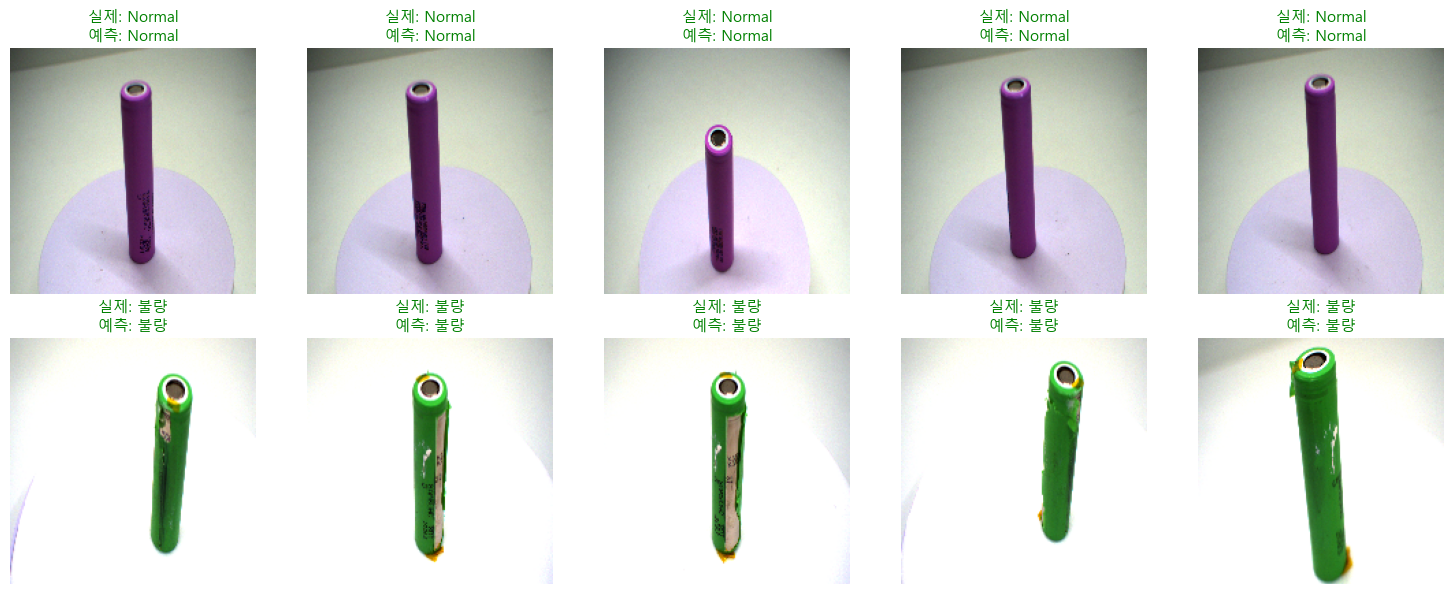

In [ ]:
import os
import json
import numpy as np
import cv2
import matplotlib.pyplot as plt
import platform
from tensorflow.keras.models import load_model

# 폰트 설정
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 설정
IMAGE_DIR = r"C:\Users\607-03\Desktop\battery3000\battery3000\images"
JSON_DIR = r"C:\Users\607-03\Desktop\battery3000\battery3000\labels"
IMG_SIZE = (128, 128)
CLASS_MAP = {"Normal": 0, "Pollution": 1, "Damaged": 2}
REVERSE_CLASS_MAP = {v: k for k, v in CLASS_MAP.items()}
model = load_model("battery_cnn_model_final.h5")

# 데이터 로드
def load_all_data(image_dir, json_dir):
    paths, labels = [], []
    normal_total, defect_total = 0, 0

    json_files = [f for f in os.listdir(json_dir) if f.endswith(".json")]
    for json_file in json_files:
        try:
            with open(os.path.join(json_dir, json_file), "r", encoding="utf-8") as f:
                anno = json.load(f)
            img_path = os.path.join(image_dir, anno["image_info"]["file_name"])
            if not os.path.exists(img_path):
                continue

            if "defects" in anno and anno["defects"]:
                label = "불량"
                defect_total += 1
            else:
                label = "Normal"
                normal_total += 1

            paths.append(img_path)
            labels.append(label)
        except:
            continue

    print(f"전체 이미지 개수: {len(paths)}")
    print(f"정상 이미지: {normal_total}, 불량 이미지: {defect_total}")
    return paths, labels

# 예측
def predict_label(image_path, model):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    pred_class = np.argmax(pred, axis=1)[0]
    return "Normal" if REVERSE_CLASS_MAP[pred_class] == "Normal" else "불량"

# 시각화
def visualize_correct_predictions(image_paths, true_labels, model):
    correct_normals = []
    correct_defects = []
    total_normals = 0
    total_correct_normals = 0

    for path, label in zip(image_paths, true_labels):
        pred = predict_label(path, model)
        if label == "Normal":
            total_normals += 1
        if pred == label:
            if label == "Normal" and len(correct_normals) < 5:
                correct_normals.append((path, label, pred))
                total_correct_normals += 1
            elif label == "불량" and len(correct_defects) < 5:
                correct_defects.append((path, label, pred))
        if len(correct_normals) == 5 and len(correct_defects) == 5:
            break

    print(f"총 정상 이미지: {total_normals}, 그중 맞춘 개수: {total_correct_normals}")
    print(f"수집된 정상 샘플: {len(correct_normals)}, 불량 샘플: {len(correct_defects)}")

    selected = correct_normals + correct_defects
    plt.figure(figsize=(15, 6))
    for i, (path, label, pred) in enumerate(selected):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (180, 180))
        plt.subplot(2, 5, i + 1)
        plt.imshow(img)
        plt.title(f"실제: {label}\n예측: {pred}", fontsize=11, color='green')
        plt.axis("off")

    plt.tight_layout()
    plt.savefig("correct_5_normal_5_defect_with_log.png")
    plt.show()

# 실행
all_paths, all_labels = load_all_data(IMAGE_DIR, JSON_DIR)
visualize_correct_predictions(all_paths, all_labels, model)